In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import torch

from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

2025-04-17 19:23:27.188647: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 19:23:27.193008: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 19:23:27.198699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 19:23:27.209847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 19:23:27.209864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

In [5]:
env = os.environ['CONDA_DEFAULT_ENV']
if env == 'workspace':
    sys.path.append('../../esm')
    from DomainPrediction.esm.esmc import ESMCLM
    from DomainPrediction.al.finetuning import ESMCLoraRegression, ESMCConFit
elif env == 'workspace-esm':
    from DomainPrediction.esm.esm2 import ESM2
    from DomainPrediction.al.finetuning import ESM2LoraRegression, ESM2ConFit
else:
    raise Exception('I designed this for my envs. Feel free to modify accordingly')

### Load Data

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/fitness_prediction/Tdomain'

In [7]:
file = os.path.join(data_path, 'dataset_2_tdomain.csv')
df = pd.read_csv(file)

In [8]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,1.730126,0,45,0.548194
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.073117,2,46,-2.615701
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [9]:
df.shape

(85, 6)

In [10]:
results_file = os.path.join(data_path, 'results_tdomain.csv')

In [11]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [12]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_OHE_ridge', 'pred_OHE_RF', 'pred_OHE_MLP', 'pred_esm2_mean_ridge',
       'pred_esm2_mean_RF', 'pred_esm2_mean_MLP', 'pred_esm2_concat_ridge',
       'pred_esm2_concat_RF', 'pred_esmc_mean_ridge', 'pred_esmc_mean_RF',
       'pred_esmc_mean_MLP', 'pred_esmc_concat_ridge', 'pred_esmc_concat_RF',
       'pred_esm2_wt_marginal', 'pred_esm2_masked_marginal',
       'pred_esm2_pseudolikelihood', 'pred_esmc_pseudolikelihood',
       'pred_esmc_wt_marginal', 'pred_esmc_masked_marginal',
       'pred_esm2_confit', 'pred_esmc_confit'],
      dtype='object')

In [13]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    test_mask = df['split_id'].isin([0, 1])

    return train_mask, test_mask

In [20]:
def get_spearmanr_bootstrap(a, b, n=1000, ci = 95):
    assert type(a) == type(b) == np.ndarray
    assert len(a) == len(b)
    corr = []
    p_values = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_values.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [100-ci, ci]) 
    # stats.t.interval(confidence=ci, df=len(corr)-1, loc=np.mean(corr), scale=np.std(corr))
    mean_corr = np.mean(corr)
    p_value = np.mean(np.array(corr) < 0)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), p_value, corr, p_values

### OHE based models

#### Get embeddings and splits

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_test = embeddings[test_mask]

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
print(f'train {train_mask.sum()} test {test_mask.sum()}')

#### Linear model

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

# df_results['pred_OHE_ridge'] = y_pred
# df_results.to_csv(results_file, index=False)

# df_results.columns[df_results.columns.str.contains('pred')]

#### Random Forest

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

df_results['pred_OHE_RF'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

#### MLP

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [2300, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 100,
        'early_stopping': False,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

df_results['pred_OHE_MLP'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

### Embedding-based Models

#### Get Embedding and splits

In [ ]:
model_choices = 'esmc'  # 'esm2', 'esmc'

if model_choices == 'esm2':
    base_model = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
elif model_choices == 'esmc':
    base_model = ESMCLM(name='esmc_600m', device='gpu')
else:
    raise ValueError('model not found')

In [ ]:
embedding_choice = 'concat' # 'mean', 'concat'

if embedding_choice == 'mean':
    embeddings = base_model.get_embeddings_mean(df['seq'])
elif embedding_choice == 'concat':
    embeddings = base_model.get_embeddings_flatten(df['seq'])
else:
    raise ValueError('model not found')

In [ ]:
train_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_test = embeddings[test_mask]

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
print(f'train {train_mask.sum()} test {test_mask.sum()}')

#### Linear Model

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

df_results[f'pred_{model_choices}_{embedding_choice}_ridge'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

#### Random Forest

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

df_results[f'pred_{model_choices}_{embedding_choice}_RF'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

#### MLP

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [1152, 512, 1], 
        'epoch': 300, 
        'batch_size': 16,
        'patience': 200,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_test, y_test))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_test_pred = surrogate.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]

df_results[f'pred_{model_choices}_{embedding_choice}_MLP'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

### Zero-Shot PLMs

In [ ]:
model_choices = 'esmc'

if model_choices == 'esm2':
    base_model = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
elif model_choices == 'esmc':
    base_model = ESMCLM(name='esmc_600m', device='gpu')
else:
    raise ValueError('model not found')

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
zero_shot_method = 'masked_marginal'

In [ ]:
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']

    if zero_shot_method == 'wt_marginal':
        score, n_muts = base_model.get_wildtype_marginal(mt_sequence, wt_sequence)
        assert n_muts == row['n_mut']
    elif zero_shot_method == 'masked_marginal':
        score, n_muts = base_model.get_masked_marginal(mt_sequence, wt_sequence)
        assert n_muts == row['n_mut']
    elif zero_shot_method == 'pseudolikelihood':
        score = base_model.pseudolikelihood(mt_sequence)
    else:
        raise ValueError('method not found')

    y_pred.append(score)

y_pred = np.array(y_pred)

In [ ]:
train_mask, test_mask = get_split_mask(df, omit_zero=False)

y = df['fitness_log'].to_numpy().astype(np.float32)

y_train = y[train_mask]
y_test = y[test_mask]

y_train_pred = y_pred[train_mask]
y_test_pred = y_pred[test_mask]

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
assert y_pred.shape[0] == df_results.shape[0]

df_results[f'pred_{model_choices}_{zero_shot_method}'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

### Regression Finetuning

In [15]:
model_choices = 'esm2'

config={'epoch': 100, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 1e-3,
        'print_every_n_epoch': 1,
        'device': 'gpu'}

if model_choices == 'esmc':
    surrogate = ESMCLoraRegression(name='esmc_600m', config=config)
elif model_choices == 'esm2':
    surrogate = ESM2LoraRegression(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', config=config)

surrogate.print_trainable_parameters(surrogate)

trainable params: 1821475 || all params: 1303439469 || trainable%: 0.14


In [16]:
surrogate

ESM2LoraRegression(
  (basemodel): ESM2(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0-32): 33 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1280, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=1280, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=1280, out_feat

In [17]:
train_mask, test_mask = get_split_mask(df, omit_zero=False)

df_train = df[train_mask]
df_test = df[test_mask]

y_train = df_train['fitness_log'].to_numpy().astype(np.float32)
y_test = df_test['fitness_log'].to_numpy().astype(np.float32)

In [18]:
surrogate.trainmodel(df_train, df_test)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /nethome/kgeorge/workspace/DomainPrediction/src/fitness_prediction/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | basemodel | ESM2      | 652 M  | train
1 | model_reg | ESM2      | 651 M  | eval 
2 | model     | PeftModel | 652 M  | train
3 | mlp       | Linear    | 1.3 K  | train
------------------------------------------------
1.8 M     Trai

Epoch: 0: train loss: 38.60412086759295 mse loss: 38.60412086759295 kl div 0.0 val loss: 19.933925449848175 mse loss: 19.91361966729164 kl div 0.20305811241269112
Epoch: 1: train loss: 37.355418750217986 mse loss: 37.305528095790315 kl div 0.4989001750946045 val loss: 19.424771547317505 mse loss: 19.39489358663559 kl div 0.29877183586359024
Epoch: 2: train loss: 37.13044221060617 mse loss: 37.000881740025115 kl div 1.2956079244613647 val loss: 18.917054548859596 mse loss: 18.86837165057659 kl div 0.4868326261639595
Epoch: 3: train loss: 35.45123423848833 mse loss: 35.31932732037136 kl div 1.319065979548863 val loss: 18.400584876537323 mse loss: 18.333707958459854 kl div 0.6687624007463455
Epoch: 4: train loss: 35.68491983413696 mse loss: 35.562799317496165 kl div 1.2212047236306327 val loss: 17.90158075094223 mse loss: 17.79703262448311 kl div 1.045479103922844
Epoch: 5: train loss: 34.46531610829489 mse loss: 34.33633404118674 kl div 1.28981990473611 val loss: 17.402997888624668 mse l

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch: 60: train loss: 5.9486421176365445 val loss: 11.333892673254013


100%|██████████| 30/30 [00:01<00:00, 15.10it/s]


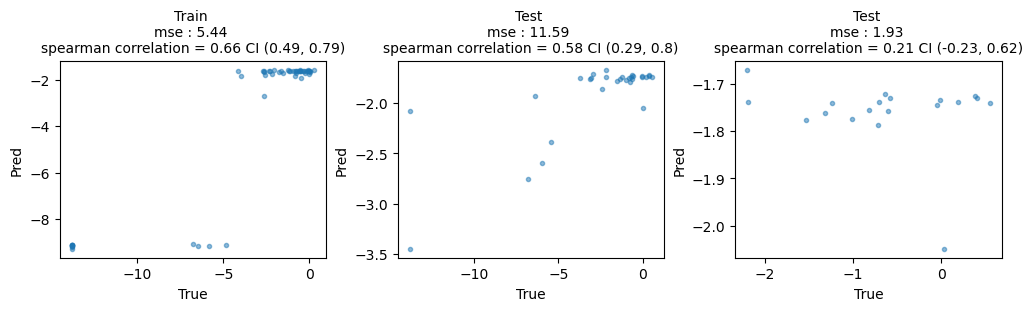

In [25]:
y_train_pred = surrogate.predict(df_train['seq'])
y_test_pred = surrogate.predict(df_test['seq'])

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [23]:
corr, ci_lower, ci_upper, p_value, *_ =  get_spearmanr_bootstrap(y_test, y_test_pred)

In [24]:
corr, ci_lower, ci_upper, p_value

(0.56, 0.27, 0.8, 0.001)

In [ ]:
y_pred = surrogate.predict(df['seq'])
assert y_pred.shape[0] == df_results.shape[0]

df_results[f'pred_{model_choices}_regfit'] = y_pred
df_results.to_csv(results_file, index=False)

df_results.columns[df_results.columns.str.contains('pred')]

### Contrastive Finetuning

In [ ]:
model_choices = 'esmc'

config={'epoch': 60, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'model_checkpoint': True,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'use_seq_head': True,
        'device': 'gpu'}

if model_choices == 'esmc':
    surrogate = ESMCConFit(name='esmc_600m', config=config)
elif model_choices == 'esm2':
    surrogate = ESM2ConFit(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', config=config)

surrogate.print_trainable_parameters(surrogate)

In [ ]:
for name, pm in surrogate.model.named_parameters():
    if pm.requires_grad:
        print(name, pm.requires_grad)
    # print(name, pm.requires_grad)

In [ ]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [ ]:
train_mask, test_mask = get_split_mask(df, omit_zero=False)

df_train = df[train_mask]
df_test = df[test_mask]

y_train = df_train['fitness_log'].to_numpy().astype(np.float32)
y_test = df_test['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate.config['lr'] = 1e-4
surrogate.config['epoch'] = 300
surrogate.trainmodel(df_train, wt_sequence, val=df_test[df_test['fitness_raw'] > 0.1])

In [ ]:
surrogate.trainer.checkpoint_callback.best_model_path

In [ ]:
surrogate.load_state_dict(torch.load(surrogate.trainer.checkpoint_callback.best_model_path)['state_dict'])

In [ ]:
y_train_pred = surrogate.predict(df_train['seq'], wt_sequence)
y_test_pred = surrogate.predict(df_test['seq'], wt_sequence)

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_test, y_test_pred, '.', alpha=0.5)
ax[2].plot(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1],
            '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_train, y_train_pred)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test, y_test_pred)
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test, y_test_pred)
ax[1].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

mse = mean_squared_error(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1])
corr, ci_lower, ci_upper, *_  = get_spearmanr_bootstrap(y_test[df.loc[test_mask, 'fitness_raw'] > 0.1], y_test_pred[df.loc[test_mask, 'fitness_raw'] > 0.1])
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {corr} CI ({ci_lower}, {ci_upper})', size=10)

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(df['seq'], wt_sequence)
# assert y_pred.shape[0] == df_results.shape[0]

# df_results[f'pred_{model_choices}_confit'] = y_pred
# df_results.to_csv(results_file, index=False)

# df_results.columns[df_results.columns.str.contains('pred')]